# The Project #
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html). A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images. The task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will showcase my ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), use OpenCV to detect faces, use tesseract to do optical character recognition, to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I encourage to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

In [1]:
import zipfile

from PIL import Image,ImageFont, ImageDraw
import pytesseract
import cv2 as cv
import numpy as np
from kraken import pageseg
from pytesseract import Output
import re

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')


In [2]:
from IPython.display import display

def  binarize(img_to_transform, threshold):
    
    """Binarization of the image passed
    input:
    img_to_transform = A pill image object to transform
    threshold = an int that specifies the treshold for the binarization
    output:
    returns a pill image object binirized(only 255 or 0 pixel luminosity values)
    """
    
    output_image = img_to_transform.convert('L')    
    n_img = np.asarray(output_image.copy())
    n_img.setflags(write=1)
    n_img[n_img >= threshold] = 255
    n_img[n_img < threshold] = 0
    return Image.fromarray(n_img)


def recognize_and_process_text(img):
    
    """Pass an image and the function detects and returns the text in string format ussing pytesseract
    input:
    img = A pill image object, the function binarizes the image to obtain a better result
    return:
    a list containing all the words detected, all puntuation signs were removed and the words are lowercased
    """
    
    text = pytesseract.image_to_string(binarize(img,150))
    processed = text.split()
    strings = [word.replace(r'’s','') for word in processed]
    strings = [re.sub(r'[^\w\s]', '', word) for word in strings]
    return [strn.lower() for strn in strings]

def faces_pictures(img):

    """
    detects faces on an image ussing cv2
    input:
    img = image in  which to detect the faces
    output:
    list of faces detected as PILL.Image objects
    """
    grayscale_picture = cv.cvtColor(np.asarray(img), cv.COLOR_BGR2GRAY)
    grayscale_picture2 = binarize(img,150)
    face_boxes = face_cascade.detectMultiScale(grayscale_picture,1.3,minNeighbors = 4)
    face_imgs = []
    for box in face_boxes:
        w = box[2]
        h = box[3]
        face_imgs.append(img.crop([box[0],box[1],box[0]+w,box[1]+h]))
    
    return face_imgs
    
def contact_sheet(images,file_name):
    
    """Creates a contact sheet with all the faces detected in the newspaper
    Input: 
    Images = list of images t append n the cntact sheet
    output = contact sheet with the images detected
    """
    
    txt_s= 30
    fnt = ImageFont.truetype('readonly/fanwood-webfont.ttf',20)
    
    if len(images) == 0:
        canvas = np.full((2*txt_s,500,3),255,dtype = np.uint8)
        canvas = Image.fromarray(canvas,mode = 'RGB')
        drawing = ImageDraw.Draw(canvas)
        drawing.text([5,2],'Results_found in file {}'.format(file_name),fill = (0,0,0),font=fnt)
        drawing.text([5,30],'But there were no faces in that file!',fill = (0,0,0),font=fnt)
        
    else:
        canvas = np.zeros((200+txt_s,500,3),dtype = np.uint8)
        canvas[:txt_s,:] = np.full(canvas[:txt_s,:].shape,255)
        canvas = Image.fromarray(canvas,mode = 'RGB')
        drawing = ImageDraw.Draw(canvas)
        drawing.text([5,5],'Results_found in file {}'.format(file_name),fill = (0,0,0),font=fnt)
        wv = sum([ima.width for ima in images])
        x = 0
        y = txt_s
    
        for im in images:
            if wv > canvas.width:
                im = im.resize([int(canvas.width/5),int((canvas.height-txt_s)/2)])
                canvas.paste(im,(x,y))
                x = x + im.width
                if x == canvas.width:
                    x = 0
                    y = y + int((canvas.height-txt_s)/2)
            else:
                if im.height>(canvas.height-txt_s) or im.width>canvas.width/3:
                    im = im.resize([int(canvas.width/5),int((canvas.height-txt_s)/2)])
                canvas.paste(im,(x,y))
                x = x + im.width
                if x == canvas.width:
                    x = 0
                    y = y + int((canvas.height-txt_s)/2)
                
    return canvas

def OCR_results(ocurrence, zip_filename ='images.zip'):
    ## Instantiate a zipfilebject and read the zipfile
    zipf = zipfile.ZipFile(zip_filename)

    for name in zipf.namelist():
        img = Image.open(zipf.open(name))
        if ocurrence.lower() in recognize_and_process_text(img):
            n_faces = faces_pictures(img)
            display(contact_sheet(n_faces,name))

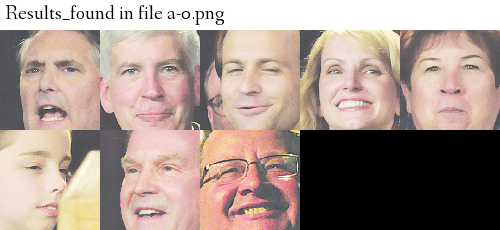

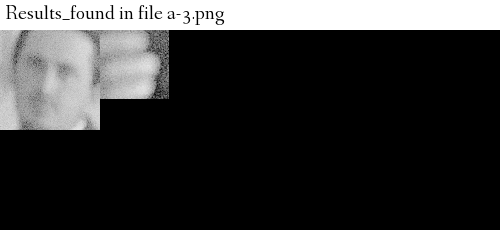

In [3]:
### Test the final OCR recognition with the word Christopher in the file 'readonly/small_img.zip'
OCR_results('Christopher',zip_filename ='small_img.zip')

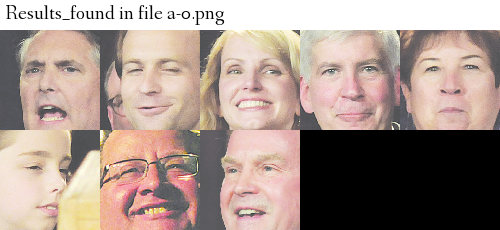

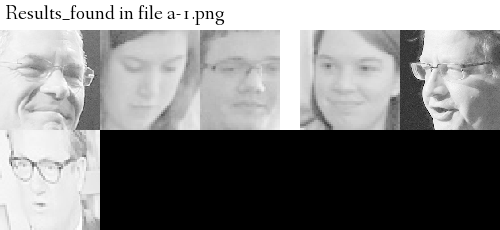

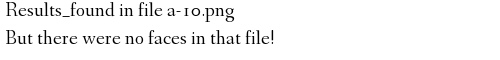

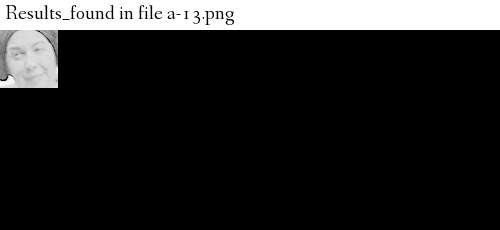

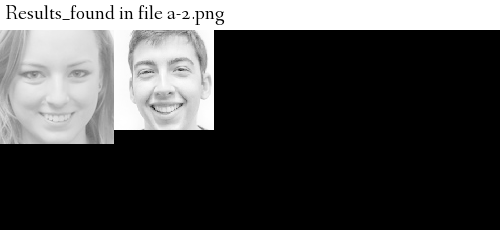

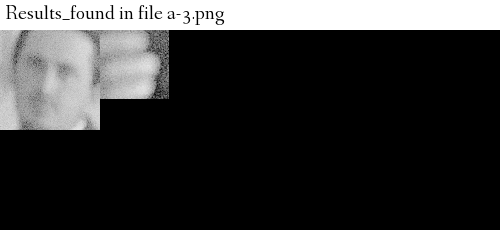

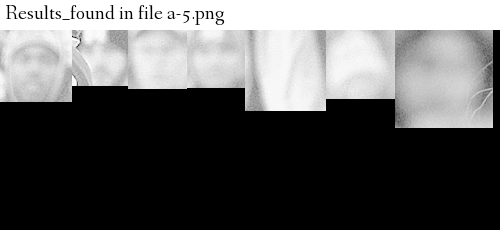

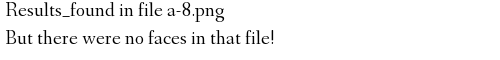

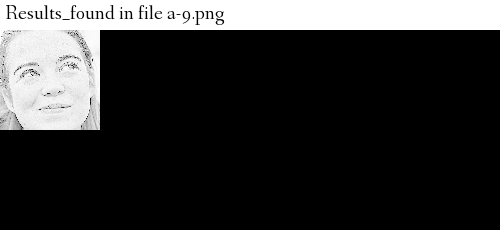

In [4]:
### Test the final OCR recognition with the word 'Mark' in the file 'images.zip'
OCR_results('Mark')

In [3]:
## Instantiate a zipfilebject and read the zipfile
zipf = zipfile.ZipFile('images.zip')


img = Image.open(zipf.open('a-9.png'))
text = recognize_and_process_text(img)
n_faces = faces_pictures(img)

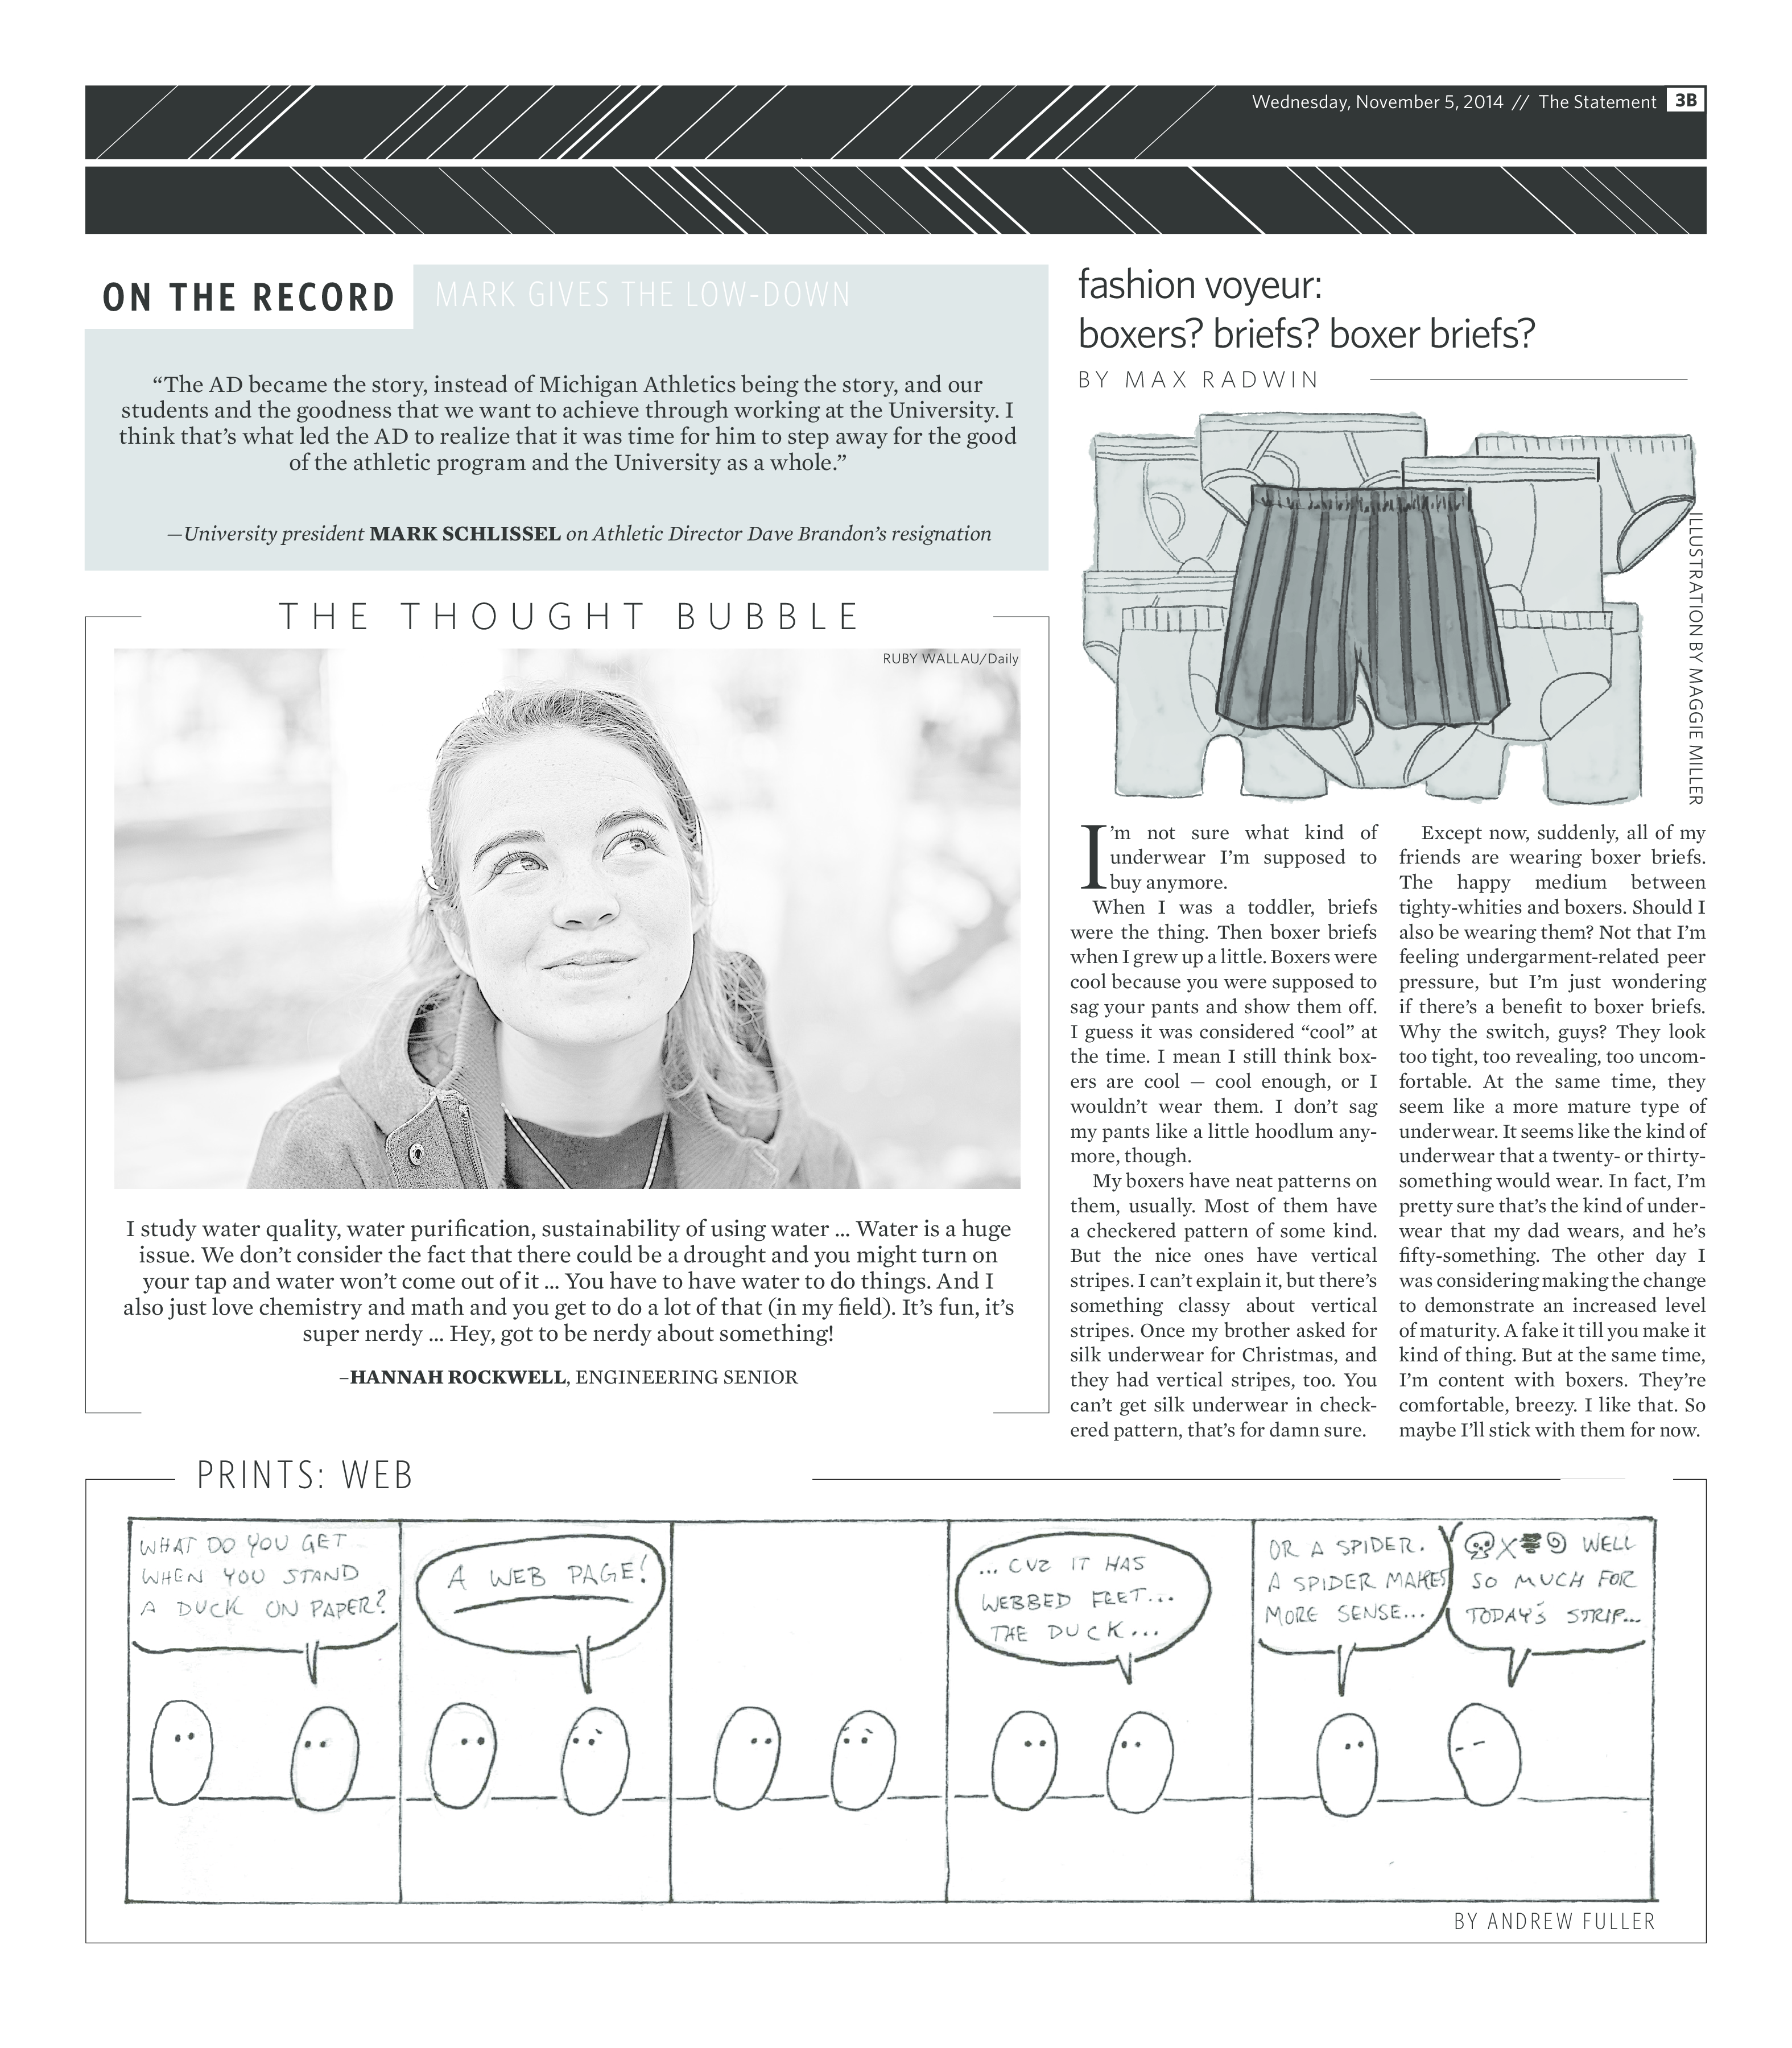

In [4]:
display(img)

In [5]:
text

['waa',
 'aa',
 'ae',
 'mber',
 '5',
 '2014',
 '',
 'the',
 'statement',
 'el',
 'on',
 'the',
 'record',
 'sa',
 'the',
 'ad',
 'became',
 'the',
 'story',
 'instead',
 'of',
 'michigan',
 'athletics',
 'being',
 'the',
 'story',
 'and',
 'our',
 'students',
 'and',
 'the',
 'goodness',
 'that',
 'we',
 'want',
 'to',
 'achieve',
 'through',
 'working',
 'at',
 'the',
 'university',
 'i',
 'think',
 'that',
 'what',
 'led',
 'the',
 'ad',
 'to',
 'realize',
 'that',
 'it',
 'was',
 'time',
 'for',
 'him',
 'to',
 'step',
 'away',
 'for',
 'the',
 'good',
 'of',
 'the',
 'athletic',
 'program',
 'and',
 'the',
 'university',
 'as',
 'a',
 'whole',
 'university',
 'president',
 'mark',
 'schlissel',
 'on',
 'athletic',
 'director',
 'dave',
 'brandon',
 'resignation',
 '',
 'the',
 'thought',
 'bubble',
 'i',
 'study',
 'water',
 'quality',
 'water',
 'purification',
 'sustainability',
 'of',
 'using',
 'water',
 '',
 'ruby',
 'wallau',
 'daily',
 'water',
 'is',
 'a',
 'huge',
 'issue'